In [1]:
# TODO Test Featuretools
# TODO Test LSTM for Feature Extraction
# Test both weighted and unweighted class approaches for better CV-LB estimation.
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
%matplotlib inline
le = preprocessing.LabelEncoder()
import re
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix
import featuretools as ft 
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
import gc

In [2]:
'''
def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()
'''

'\ndef plot_confusion_matrix(truth, pred, classes, normalize=False, title=\'\'):\n    cm = confusion_matrix(truth, pred)\n    if normalize:\n        cm = cm.astype(\'float\') / cm.sum(axis=1)[:, np.newaxis]\n    \n    plt.figure(figsize=(10, 10))\n    plt.imshow(cm, interpolation=\'nearest\', cmap=plt.cm.Blues)\n    plt.title(\'Confusion matrix\', size=15)\n    plt.colorbar(fraction=0.046, pad=0.04)\n    tick_marks = np.arange(len(classes))\n    plt.xticks(tick_marks, classes, rotation=45)\n    plt.yticks(tick_marks, classes)\n\n    fmt = \'.2f\' if normalize else \'d\'\n    thresh = cm.max() / 2.\n    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):\n        plt.text(j, i, format(cm[i, j], fmt),\n                 horizontalalignment="center",\n                 color="white" if cm[i, j] > thresh else "black")\n\n    plt.ylabel(\'True label\')\n    plt.xlabel(\'Predicted label\')\n    plt.grid(False)\n    plt.tight_layout()\n'

In [3]:
def plot_feature_distribution(df1, df2, label1, label2, features,a=2,b=5):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(17,9))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

In [4]:
def balanced_cv(conf_mat):
    assert len(conf_mat.shape) == 2
    rows, columns = conf_mat.shape
    intra_class_scores = np.zeros((1, columns))
    column_sums = np.sum(conf_mat, axis=0)
    for c in range(columns):
        intra_class_scores[0][c] = float(conf_mat[c][c])/column_sums[c]
        
    balanced_score = np.mean(intra_class_scores)
    return balanced_score

In [5]:
def plot_feature_class_distribution(classes,tt, features,a=5,b=2):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        for clas in classes:
            ttc = tt[tt['surface']==clas]
            sns.kdeplot(ttc[feature], bw=0.5,label=clas)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

In [6]:
data = pd.read_csv('X_train.csv')
sampl = pd.read_csv('sample_submission.csv')
test = pd.read_csv('X_test.csv')
target = pd.read_csv('y_train.csv')

In [7]:
totalt = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(5)

In [8]:
totalt = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(5)

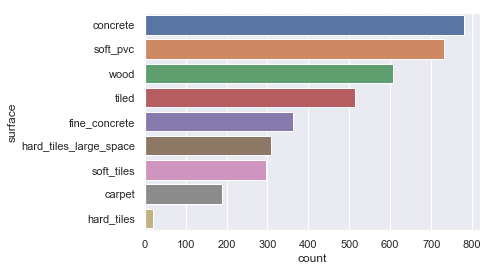

In [9]:
sns.set(style='darkgrid')
sns.countplot(y = 'surface',
              data = target,
              order = target['surface'].value_counts().index)
plt.show()

In [10]:
data.head()

row_id  series_id  measurement_number  orientation_X  orientation_Y  \
0    0_0          0                   0       -0.75853       -0.63435   
1    0_1          0                   1       -0.75853       -0.63434   
2    0_2          0                   2       -0.75853       -0.63435   
3    0_3          0                   3       -0.75852       -0.63436   
4    0_4          0                   4       -0.75852       -0.63435   

   orientation_Z  orientation_W  angular_velocity_X  angular_velocity_Y  \
0       -0.10488       -0.10597            0.107650            0.017561   
1       -0.10490       -0.10600            0.067851            0.029939   
2       -0.10492       -0.10597            0.007275            0.028934   
3       -0.10495       -0.10597           -0.013053            0.019448   
4       -0.10495       -0.10596            0.005135            0.007652   

   angular_velocity_Z  linear_acceleration_X  linear_acceleration_Y  \
0            0.000767               -0.74857                 2.1030   
1            0.003385                0.33995                 1.5064   
2           -0.005978               -0.26429                 1.5922   
3           -0.008974                0.42684                 1.0993   
4            0.005245               -0.50969                 1.4689   

   linear_acceleration_Z  
0                -9.7532  
1                -9.4128  
2                -8.7267  
3               -10.0960  
4               -10.4410

In [11]:
def feat_eng(data):
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 +
                             data['angular_velocity_Z'])** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 +
                             data['linear_acceleration_Z'])**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 +
                            data['orientation_Z'])**0.5
    data['z_planar_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2)**0.5
    #Lets derive one more column since there is a relationship in velocity and acceleration
    # v = u + a*t , u is initial velocty. if u = 0, then v = at means t = v/a
    # but value of acceleration is more and value of velocity is less, lets do a/v relation
    # data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    # Deriving more feature, since we are reducing rows now, we should know min,max,mean values
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df
    

In [12]:
data = feat_eng(data)
test = feat_eng(test)
# print("Data feature count:", data.columns)
# print("Test feature count:", test.columns)
data.shape

(3810, 140)

<Figure size 432x288 with 0 Axes>

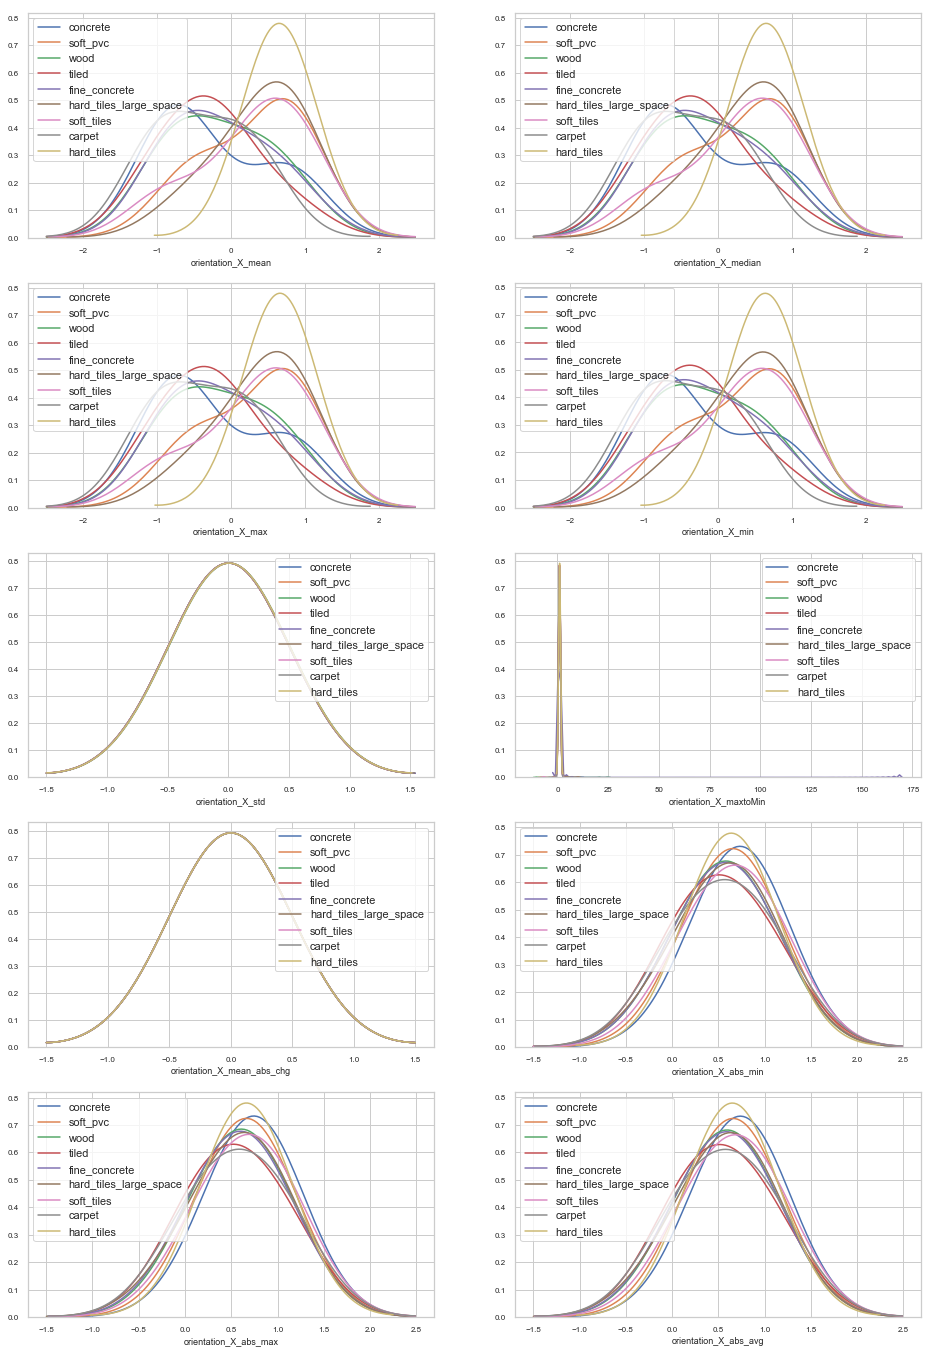

In [13]:
'''
features = data.columns.values[0:10]
classes = (target['surface'].value_counts()).index
aux = data.merge(target, on='series_id', how='inner')
plot_feature_class_distribution(classes, aux, features)
'''

In [14]:
# data.head()
# print(data.columns)

In [15]:
# Filling missing data by zeroes
data.fillna(0,inplace=True)
data.replace(-np.inf,0,inplace=True)
data.replace(np.inf,0,inplace=True)
test.fillna(0,inplace=True)
test.replace(-np.inf,0,inplace=True)
test.replace(np.inf,0,inplace=True)

In [16]:
#Label Encoding
target['surface'] = le.fit_transform(target['surface'])

In [17]:
print(aux)

      series_id  orientation_X_mean  orientation_X_median  orientation_X_max  \
0             0           -0.758666             -0.758530          -0.758220   
1             1           -0.958606             -0.958595          -0.958370   
2             2           -0.512057             -0.512035          -0.509440   
3             3           -0.939169             -0.939170          -0.938840   
4             4           -0.891301             -0.890940          -0.886730   
5             5            0.464712              0.464700           0.465450   
6             6           -0.402356             -0.402395          -0.398560   
7             7           -0.925909             -0.925900          -0.925590   
8             8            0.012041              0.010983           0.018242   
9             9            0.789137              0.789900           0.824630   
10           10            0.848894              0.849040           0.850250   
11           11            0.494943     

[3810 rows x 143 columns]


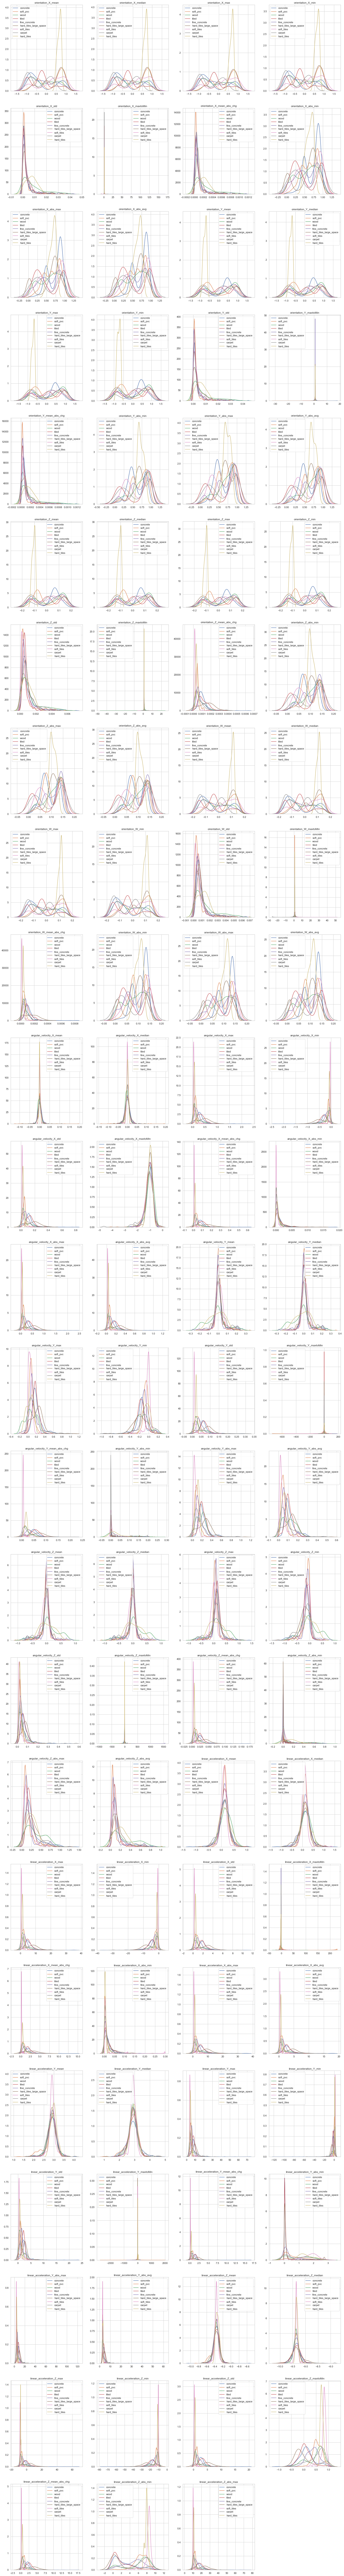

In [18]:
plt.figure(figsize=(26, 216))
for i,col in enumerate(aux.columns[1:100]):
    ax = plt.subplot(26,4,i+1)
    ax = plt.title(col)
    for surface in classes:
        surface_feature = aux[aux['surface'] == surface]
        sns.kdeplot(surface_feature[col], label = surface)

In [ ]:
split_count = 5
folds = StratifiedKFold(n_splits=split_count, shuffle=True, random_state=1337)
# folds = GroupShuffleSplit(n_splits=split_count)

In [ ]:
predicted = np.zeros((test.shape[0],9))
# measured= np.zeros((data.shape[0]))
score = 0
balanced_cv_sum = 0
# Balanced model training gives slightly worse results on pubLB.
model = RandomForestClassifier(n_estimators=200, random_state=1337)
# model = XGBClassifier(tree_method='gpu_hist')
# model = LGBMClassifier(device='gpu')
for times, (trn_idx, val_idx) in enumerate(folds.split(data.values,target['surface'].values)):
    model.fit(data.iloc[trn_idx],target['surface'][trn_idx])
    # measured[val_idx] = model.predict(data.iloc[val_idx])
    # predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(data.iloc[val_idx],target['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(data.iloc[val_idx],target['surface'][val_idx])))
    cm = confusion_matrix(model.predict(data.iloc[val_idx]), target['surface'].iloc[val_idx])
    '''
    plt.figure()
    sns.heatmap(cm, annot=True, cmap="YlOrBr")
    '''
    balscore = balanced_cv(cm)
    print('balanced cv score', balscore)
    balanced_cv_sum +=balscore
    gc.collect()
print('Avg Accuracy', score / folds.n_splits)
print('Avg Balanced Accuracy', balanced_cv_sum / folds.n_splits)

In [ ]:
model.fit(data, target['surface'])
predicted = model.predict_proba(test)
sampl['surface'] = le.inverse_transform(predicted.argmax(axis=1))
sampl.to_csv('submission.csv', index=False)
# sampl.head()